In [25]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.filterwarnings(action='once')

plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid')

In [3]:
import io
import urllib3
from zipfile import ZipFile

link = 'https://cloud.uma.tech/index.php/s/XKJg3Bc8FZ8k5Fp/download'

http = urllib3.PoolManager()
response = http.request('GET', link)
data = response.data
data = ZipFile(io.BytesIO(data))

/home/evgeny/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [13]:
train = pd.read_csv(data.open('TRAIN_PREPARED.csv'), 
                    index_col='user')
X_test = pd.read_csv(data.open('TEST_PREPARED.csv'), 
                   index_col='user')

train_additional = pd.read_csv(data.open('TRAIN_ADDITIONAL_DATA.csv'), 
                               index_col='user')
test_additional = pd.read_csv(data.open('TEST_ADDITIONAL_DATA.csv'), 
                              index_col='user')

In [0]:
# train = pd.merge(left=train, right=train_additional, how='left', on='user')
# test = pd.merge(left=test, right=test_additional, how='left', on='user')

In [15]:
X_train = train.drop(columns=['label'])
y_train = train[['label']]

# train_users = train[['user']]
# test_users = test[['user']]

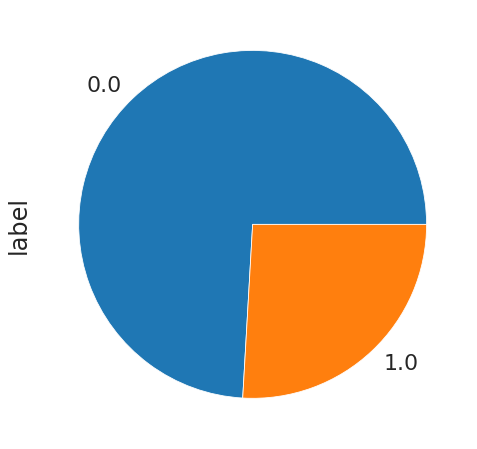

In [16]:
sns.set_context(context='paper', font_scale=2.5)
plt.figure(figsize=(12, 8))
y_train['label'].value_counts().plot(kind='pie')
plt.show()

In [11]:
def count_days(data):
  data['days'] = (pd.to_datetime(data['last_date']) - pd.to_datetime(data['first_date'])).dt.days
  data['days_to_cut'] = (pd.to_datetime(data['cut_date']) - pd.to_datetime(data['last_date'])).dt.days
  return data.drop(columns=['first_date', 'last_date', 'cut_date'])

In [18]:
X_train = count_days(X_train)
X_test = count_days(X_test)

# Logistic Regression

In [0]:
scorer = make_scorer(mse)
cv = KFold(n_splits=5, shuffle=True)

In [0]:
lr_params = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10]
}

logistic_gs = GridSearchCV(estimator=LogisticRegression(), param_grid=lr_params,
                           scoring=scorer, n_jobs=-1, cv=cv)
logistic_gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_squared_error), verbose=0)

# Gradient Boosting

In [0]:
gb_params = {
    'n_estimators': [i for i in range(80, 201, 10)]
}

gradient_gs = GridSearchCV(estimator=GradientBoostingClassifier(), 
                           param_grid=gb_params, scoring=scorer, 
                           n_jobs=-1, cv=cv)
gradient_gs.fit(X_train.iloc[:20000], y_train.iloc[:20000])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weig...
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
              

# Neural network

In [0]:
nn_params = {
    'hidden_layer_sizes': [(10, 5), (9, 4), (8, 4), (7, 3), (6, 3), (5, 2)]
}

neural_gs = GridSearchCV(estimator=MLPClassifier(), 
                         param_grid=nn_params, scoring=scorer, 
                         n_jobs=-1, cv=cv)
neural_gs.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
      

# XGBoost

In [29]:
%%time
xgb_params = {
    'n_estimators': 200,
    'max_depth': 6,
    'n_jobs': -1
}

clf = xgb.XGBClassifier(**xgb_params)
clf.fit(X_train, y_train)

/home/evgeny/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 8min 5s, sys: 2.6 s, total: 8min 8s
Wall time: 1min 7s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [32]:
predictions = clf.predict(X_test)

In [41]:
predictions_df = pd.DataFrame()

predictions_df['user'] = X_test.index
predictions_df['prediction'] = predictions

In [42]:
predictions_df.to_csv('submission.csv', index=False)